# CS 506 HW1 Solution
Name: Taowen Dong

### 1. Understandking K-means Clustering

(Please fill out the functions in k_means_clustering.py)

### 2. Working with the Algorithms

In [1]:
from typing import List, Dict, Tuple
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
import numpy as np
from sklearn import mixture

# feel free to add more functions such as discard missing examples

def read_dataset(dataset_path: str):
    """
    read in NYC dataset and return a dataset type of your choice
    :param dataset_path: the string path to the dataset file
    :return: dataset
    """
    dataset = pd.read_csv(dataset_path)
    dataset['price'] = dataset['price'].replace('[\$,]', '', regex=True).astype(float)
    # subset clustering col
    df = dataset.loc[:,["longitude","latitude","price"]].values
    
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(df)
    dfs = pd.DataFrame(x_scaled)
    return dfs


def cluster_nyc_listings():
    """
    cluster AirBnb listings using k-means++, hierarchical, and GMM
    :return: 
    """
    dfs = read_dataset('listings.csv')
    
    print('k-means:')
    kmeans = KMeans(n_clusters = 3, max_iter = 300, init = 'k-means++', n_init = 10, random_state = 0)
    y_kmeans = kmeans.fit_predict(dfs)
    print(y_kmeans)
    print('hierarchical:')
    dfs = read_dataset('listings.csv')
    
    dendrogram_1 = sch.dendrogram(sch.linkage(dfs, method = 'ward'))
    plt.title('Dendograms')
    plt.xlabel('AirBnb Listings')
    plt.ylabel('Euclidean distances')
    plt.show()
    print('GMM:')
    gmm = mixture.GaussianMixture(n_components=3) 
    gmm.fit(dfs)
    cluster = gmm.predict(dfs)
    cluster_probabilities = gmm.predict_proba(dfs)
    print(cluster)
    
    

k-means:
[0 0 1 ... 1 2 1]
hierarchical:


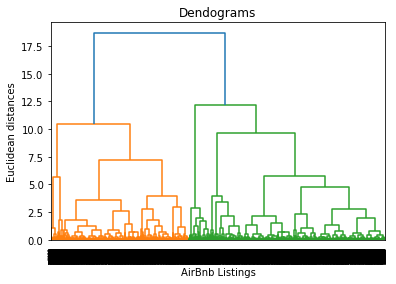

GMM:
[1 2 2 ... 2 2 2]


In [2]:
cluster_nyc_listings()

### 2b List a few bullet points describing the pros and cons of the various clustering algorithms.

Advantages of Kmeans: 
 - computationally efficient 
 - creates clusters closer than hierarchical clustering 
 
Disadvantages of Kmeans: 
 - does not have a measure of the probability or uncertainty of cluster assignments 
 - is sensitive to outliers and initial seeds 
 - The value is unknown of K (grouping). Although the elbow method or domain knowledge can be used to determine K, this uncertainty can negatively affect the grouping results. 
 - Kmeans also does not perform well with clusters of different densities. 

Advantages of hierarchical grouping: 
 - able to reveal hierarchy in data, can show information such as divergent evolution of species
 - easier decision on  number of  dendrogram groupings 
 
Disadvantages of hierarchical grouping: 
 - hierarchical grouping is computationally intensive via Algorithm cannot go back and undo what was not done correctly reacts to outliers and noise 

Advantages of GMM: 
 - very fast Algorithm 
 - takes into account that  clustering may be more secure for some points  than for others 
 
Disadvantages of GMM: 
 - If the data does not have enough points per group, it is difficult to estimate the covariance matrices and the algorithm can diverge and find solutions with infinite probability.

### 3 Data Visualization
### 3a Produce a Heatmap. Is this heatmap useful in order to draw conclusions about the expensiveness of areas within NYC? if not, why?

In [4]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import mean
df = pd.read_csv('listings.csv')
def generate_base_map(default_location: Tuple[float, float]=[40.693943, -73.985880]):
    base_map = folium.Map(location=default_location)
    return base_map
                      
base_map = generate_base_map()
HeatMap(
    data=df[["latitude", "longitude", "price"]]
    .groupby(["latitude", "longitude"])
    .mean()
    .reset_index()
    .values.tolist(),
    radius=8,
    max_zoom=13,
).add_to(base_map)
base_map.save("index.html")
                      

This heatmap doesn't make sense because  there are color gradients for different price groups, but there is no legend showing the corresponding price range. We don't know which color represents which price range, so we don't know which range is expensive / cheap.

### 3b Visualize the clusters by plotting the longitude / lattitude of every listings in a scatter plot

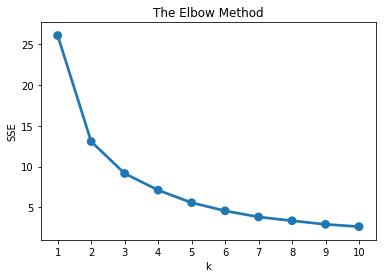

In [22]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df[df.columns[6:8]])
    sse[k] = kmeans.inertia_
    
# plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [44]:
def visualize_clusters():
    kmeans = KMeans(n_clusters=5, init ='k-means++')
    kmeans.fit(df[df.columns[6:8]]) # column 6 & 7 is latitude and longitude
    labels = kmeans.predict(df[df.columns[6:8]])
    centers = kmeans.cluster_centers_
    df['label'] = labels

    facet = sns.lmplot(data=df, x='latitude', y='longitude', hue='label', fit_reg=False, legend=True, legend_out=True)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    
    clustering = defaultdict(list)
    points = np.array(df[df.columns[9]])
    for label, point in zip(labels, points):
        clustering[label].append(point)
    
    # calculate the average price
    averages = []
    for idx in sorted(clustering):
        prices = clustering[idx]
        averages.append(mean(prices))
    return averages

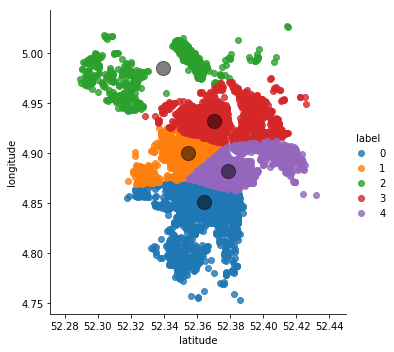

In [45]:
averages = visualize_clusters()

### 3c For every cluster, report the average price of the listings within this cluster

In [46]:
print(averages)

[140, 172, 147, 142, 170]


### 3d Bonus point (provide a plot on an actual NYC map)

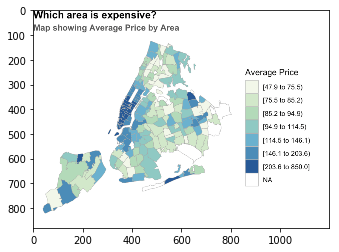

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('nyc.jpg')
imgplot = plt.imshow(img)
plt.show()

### 3e Are the findings in agreement with what you have in mind about the cost of living for neighborhoods in NYC? If you are unfamiliar with NYC, you can consult the web.

Yes, the findings is basically in agreement with the actually cost of living in NYC. In the part 1 of nyc is the most exenpensive, and other places are relatively cheaper. 

### 4. Image Manipulation

In [47]:
def get_centroids(samples, clusters):
    """
    Find the centroid given the samples and their cluster.
    :param samples: samples.
    :param clusters: list of clusters corresponding to each sample.
    :return: an array of centroids.
    """
    cluster_label = np.unique(clusters)
    centroids = []

    for label in cluster_label:
        rows_cluster = [] #store pixel rows for each cluster
        for i in range(len(clusters)):
            if clusters[i] == label:
                rows_cluster.append(i)
            
        cluster_mean = np.mean(samples[rows_cluster,:], axis=0)
        centroids.append(cluster_mean.reshape(1,3))
    new_centroids = np.concatenate(centroids, axis=0)

    return new_centroids

In [48]:
def find_closest_centroids(samples, centroids):
    """
    Find the closest centroid for all samples.
    :param samples: samples.
    :param centroids: an array of centroids.
    :return: a list of cluster_id assignment.
    """

    results = []

    for row in range(samples.shape[0]):
        diff = samples[row] - centroids
        distance = (diff[:,0] **2 + diff[:,1] **2 + diff[:,2] **2) ** .5
        results.append(np.argmin(distance)) # return index - cluster assignment

    return results

In [49]:
def choose_random_centroids(samples, K):
    """
    Randomly choose K centroids from samples.
    :param samples: samples.
    :param K: K as in K-means. Number of clusters.
    :return: an array of centroids.
    """
    shuffle_samples = np.random.permutation(samples)

    randos = shuffle_samples[0:K,:]
    
    return randos 

In [50]:
def run_k_means(samples, initial_centroids, n_iter):
    """
    Run K-means algorithm. The number of clusters 'K' is defined by the size of initial_centroids
    :return: a pair of cluster assignment and history of centroids.
    """

    centroid_history = []
    current_centroids = initial_centroids #random centroid
    clusters = []
    for iteration in range(n_iter):
        centroid_history.append(current_centroids)
        print("Iteration %d, Finding centroids for all samples..." % iteration)
        clusters = find_closest_centroids(samples, current_centroids)
        print("Recompute centroids...")
        current_centroids = get_centroids(samples, clusters)

    return clusters, centroid_history

In [53]:
# You need to add more functions here
import cv2
import numpy as np
import pandas as pd
import random
import sys
from collections import defaultdict

def display_image(image):
    cv2.imshow("Display Window", image)
    cv2.imwrite('image_output.png',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def cluster_image(image_path: str):
    # read in image
    img = cv2.imread(image_path)
    depth, rows, columns = img.shape

    # k means cluster image and reassign pixel value
    samples = img.reshape(depth*rows, columns)
    centroids = choose_random_centroids(samples,10)


    clusters, centroid_history = run_k_means(samples,centroids, n_iter=25)
    pixel_val = []

    #generate new image, loop cluster labels
    for label in clusters: 
        #replace cluster assignments with last iter centroids
        replace_centroid = np.array(centroid_history[-1][label]) 
        pixel_val.append(replace_centroid)
    new_img = np.concatenate(pixel_val)
    new_img_int = new_img.astype('uint8')
    image = new_img_int.reshape(depth, rows, columns)
    
    # display image
    display_image(image)


In [ ]:
cluster_image('boston-1993606_1280.jpg')

Iteration 0, Finding centroids for all samples...
Recompute centroids...
Iteration 1, Finding centroids for all samples...
Recompute centroids...
Iteration 2, Finding centroids for all samples...
Recompute centroids...
Iteration 3, Finding centroids for all samples...
Recompute centroids...
Iteration 4, Finding centroids for all samples...
Recompute centroids...
Iteration 5, Finding centroids for all samples...
Recompute centroids...
Iteration 6, Finding centroids for all samples...
Recompute centroids...
Iteration 7, Finding centroids for all samples...
Recompute centroids...
Iteration 8, Finding centroids for all samples...
Recompute centroids...
Iteration 9, Finding centroids for all samples...
Recompute centroids...
Iteration 10, Finding centroids for all samples...
Recompute centroids...
Iteration 11, Finding centroids for all samples...
Recompute centroids...
Iteration 12, Finding centroids for all samples...
Recompute centroids...
Iteration 13, Finding centroids for all samples.